In [1]:
import xarray as xr
import climtas.io
import dask
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33853 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33853/status,
Dashboard: http://127.0.0.1:33853/status,Workers: 4
Total threads: 4,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44371,Workers: 4
Dashboard: http://127.0.0.1:33853/status,Total threads: 4
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.160:44549,Total threads: 1
Dashboard: http://10.0.128.160:37113/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:34801,


In [3]:
anom = xr.open_dataarray('/g/data/w40/rl5183/progress_files/anom_prate.nc', chunks={'member':1}).sel(time=slice('1950-9', '1999-12')) # take time slice a few months larger on either side for smoothing

In [4]:
anom

,Array,Chunk
Bytes,22.58 GiB,292.68 MiB
Shape,"(79, 592, 180, 360)","(1, 592, 180, 360)"
Count,159 Tasks,79 Chunks
Type,float64,numpy.ndarray


In [5]:
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [6]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [7]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1950-11', '1999-10'))/sst_std

In [8]:
# Take the mean over every quarter
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [9]:
def ensemble_correlation(data, nino):
    
    anom = data
    
    # Smooth with 3-month running mean
    anom_rolling = anom.rolling(time=3).mean().sel(time=slice('1950-11', '1999-10'))
    
    # Take mean over every quarter 
    quarterly_anom = anom_rolling.resample(time='QS-NOV').mean('time')

    # Calculate instantaneous regression 
    quarterly_correlation = func.correlate_nino_by_month(quarterly_anom, nino)
    
    return quarterly_correlation 

In [10]:
correlation_list = []
for m in anom.member:
    correlation_list.append(ensemble_correlation(anom.sel(member=m), nino_ndj))

In [11]:
correlations = xr.concat(correlation_list, dim='member')

In [12]:
correlations 

<xarray.DataArray (member: 79, month: 4, latitude: 180, longitude: 360)>
array([[[[-2.46793094e-01, -2.45920441e-01, -2.45672875e-01, ...,
          -2.47421810e-01, -2.47178123e-01, -2.47026579e-01],
         [-2.87983245e-01, -2.87338097e-01, -2.87084899e-01, ...,
          -2.90114736e-01, -2.89885050e-01, -2.89176015e-01],
         [-3.01593563e-01, -3.01692102e-01, -3.01785219e-01, ...,
          -3.03318217e-01, -3.02870064e-01, -3.01908879e-01],
         ...,
         [ 3.55370290e-02,  3.49170698e-02,  3.42756166e-02, ...,
           3.91328069e-02,  3.79259126e-02,  3.70047640e-02],
         [-2.38478019e-02, -2.34783531e-02, -2.33234548e-02, ...,
          -2.52861084e-02, -2.52234381e-02, -2.47593736e-02],
         [-7.35147883e-02, -7.32574122e-02, -7.31882260e-02, ...,
          -7.42562638e-02, -7.39815253e-02, -7.36235416e-02]],

        [[ 1.38897184e-01,  1.38190692e-01,  1.37681653e-01, ...,
           1.40904639e-01,  1.40198237e-01,  1.39496470e-01],
         [ 7.18451506e-02,  6.95223887e-02,  6.74280624e-02, ...,
           7.74874788e-02,  7.56886259e-02,  7.35383322e-02],
         [ 3.96489388e-02,  3.76481546e-02,  3.58733016e-02, ...,
           4.64913816e-02,  4.42912756e-02,  4.20122250e-02],
...
         [ 1.04033020e-02,  9.37308070e-03,  9.89651818e-03, ...,
           1.46305879e-02,  1.36186355e-02,  1.26064222e-02],
         [-2.60456077e-02, -2.57516665e-02, -2.60517776e-02, ...,
          -2.51960540e-02, -2.55507145e-02, -2.63675686e-02],
         [-6.64421788e-02, -6.69299299e-02, -6.69311538e-02, ...,
          -6.60932151e-02, -6.62764161e-02, -6.64938345e-02]],

        [[ 1.47894615e-01,  1.48583160e-01,  1.49447102e-01, ...,
           1.48083401e-01,  1.47740070e-01,  1.47389134e-01],
         [ 3.21474988e-02,  3.41344608e-02,  3.62996906e-02, ...,
           3.10742804e-02,  3.14611699e-02,  3.15589557e-02],
         [-6.73983812e-02, -6.46260947e-02, -6.21696505e-02, ...,
          -6.82277220e-02, -6.85828631e-02, -6.85067836e-02],
         ...,
         [ 3.20615038e-01,  3.24239581e-01,  3.27463696e-01, ...,
           3.13681194e-01,  3.15420564e-01,  3.17973434e-01],
         [ 2.16572117e-01,  2.18975717e-01,  2.20827338e-01, ...,
           2.15228739e-01,  2.15563066e-01,  2.16143800e-01],
         [ 1.68359268e-01,  1.68676970e-01,  1.69236817e-01, ...,
           1.69394156e-01,  1.68502600e-01,  1.68788614e-01]]]])
Coordinates:
  * member     (member) int64 1 2 3 4 5 6 7 8 9 ... 72 73 74 75 76 77 78 79 80
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * month      (month) int64 2 5 8 11

In [13]:
# Save as netcdf
correlations.to_netcdf('/g/data/w40/rl5183/20CR/precip/monthly_precip_correlations_all_members_1950_2000.nc')

In [14]:
correlations = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/monthly_precip_correlations_all_members_1950_2000.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0, 0.5, 'Pearsons r')

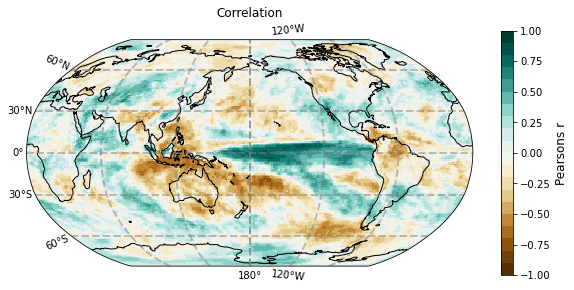

In [15]:
# Plot first member to check 
fig = plt.figure(figsize=(10,5))

vmin=-1
vmax=1

ax = fig.add_subplot(111, projection=ccrs.Robinson(180))
C = correlations.sel(month=11).sel(member=1).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Correlation')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Pearsons r', fontsize=12)

# plt.savefig('ensemble_mean_corr_prate.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [16]:
# Calculate standrd deviation between ensemble members
ensemble_std = np.apply_along_axis(np.std, 0, correlations)

In [17]:
# Covert to xarray
ensemble_std = xr.DataArray(ensemble_std, coords=correlations.mean(dim='member').coords)
# Save as netcdf 
ensemble_std.to_netcdf('/g/data/w40/rl5183/20CR/precip/prate_ensemble_std_corr_1950_2000.nc')